# -- Objetivo do problema
    
    --1.0. Previsão do primeiro destino que um novo usuário irá escolher.
    
    --Por que?
        --Quak tipo de modelo de negócio do Airbnb
            --Marketplace( Conecta pessoas que oferecem acamodação, com pessoas que estão procurando acomodação )
            --Oferta ( pessoas oferecendo acomodação )
                -- Tamanho do portfolio
                -- Diversidade/densidade de portfolio.
                -- Preço Médio
                
            -- Demanda ( pessoas procurando acomodação )
                -- Numero de Usuários
                -- LTV ( Lifetime Value )
                -- CAC ( Client acquisition cost )
                
            -- Gross Revenue = (phi*Numero cliente) - CAC
                
            -- Demanda ( pessoas procurando acomodação )
            
--Proposta da solução
  - Modelo de previsão do primeiro destino de um novo usuário.
  - 1.0. Predições e salvar em uma tabela do banco de dados.
  - 2.0. API
        - Input: usuário e suas caracteristicas
        - output: usuario e suas caracteristicas com a coluna prediction

# 0.0. Imports 

In [35]:
import random

import pandas  as pd 
import numpy   as np 
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import classification_report, accuracy_score, balanced_accuracy_score, cohen_kappa_score
from scikitplot.metrics      import plot_confusion_matrix

from keras import models
from keras import layers

## 0.1. Helper Functions 

In [2]:
def numeric_statistics( df ):
    
    dic = {
        "type": df.dtypes.values,
        "Unique_Values": df.nunique().values,
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )

# 1.0. Data Description

In [3]:
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )

# df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )

In [4]:
df_raw.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1. Data Dimensions  

In [5]:
print(f'Number of Rows: {df_raw.shape[0]}') 
print(f'Number of Columns: {df_raw.shape[1]}') 

Number of Rows: 213451
Number of Columns: 16


## 1.2. Data types 

In [6]:
df_raw.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.3. Check NA 

In [7]:
df_raw.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## 1.4. Description Analysis 

In [8]:
num_attributes = df_raw.select_dtypes( include=['int64','float64'] )
cat_attributes = df_raw.select_dtypes( include='object')

# num_attributes_sessions = df_raw.select_dtypes( include=['int64','float64'] )
# cat_attributes_sessions = df_raw.select_dtypes( include='object' )

In [9]:
numeric_statistics( num_attributes )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
timestamp_first_active,int64,213451,2.013085e+13,2.013091e+13,9.253717e+09,2.009032e+13,2.014063e+13,5.031119e+10,-0.861578,0.355882
age,float64,127,4.966834e+01,3.400000e+01,1.556666e+02,1.000000e+00,2.014000e+03,2.013000e+03,12.422586,153.568929
signup_flow,int64,17,3.267387e+00,0.000000e+00,7.637707e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.234366,3.324444


# 2.0. Feature Engineering

In [10]:
df2 = df_raw.copy()

## 2.1. FillNA

In [11]:
# date_first_booking
# age
# first_affiliate_tracked

#initialy
df2 = df2.dropna()

## 2.2. Change Data Types 

In [12]:
aux_01 = df2.sample().T
aux_02 = df2.sample().dtypes

pd.concat( [aux_01,aux_02], axis=1 )

,141169,0
id,itptfwlm9c,object
date_account_created,2014-01-13,object
timestamp_first_active,20140113135306,int64
date_first_booking,2014-02-23,object
gender,FEMALE,object
age,61.0,float64
signup_method,basic,object
signup_flow,25,int64
language,en,object
affiliate_channel,direct,object


In [13]:
# date_account_created
df2['date_account_created'] = pd.to_datetime( df2['date_account_created'] )

# timestamp_first_active
df2['timestamp_first_active'] = pd.to_datetime( df2['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date first_booking 
df2['date_first_booking'] = pd.to_datetime( df2['date_first_booking'] )  
                                           
# age 
df2['age'] = df2['age'].astype( 'int64' )

## 2.3. Check Blanced Data

In [14]:
df2['country_destination'].value_counts( normalize=True )

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 3.0. Data Filtering

In [15]:
df3 = df2.copy()

# 4.0. EDA

In [16]:
df4 = df3.copy()

# 5.0. Data Preparation 

In [17]:
df5 = df4.copy()

df5_dummys = pd.get_dummies( df5.drop( ['id','country_destination'], axis=1 ) )

df5 = pd.concat( [ df5[['id','country_destination']], df5_dummys], axis=1 )

# 6.0. Feature Selection

In [18]:
df5.columns

Index(['id', 'country_destination', 'date_account_created',
       'timestamp_first_active', 'date_first_booking', 'age', 'signup_flow',
       'gender_-unknown-', 'gender_FEMALE', 'gender_MALE',
       ...
       'first_browser_Safari', 'first_browser_SeaMonkey', 'first_browser_Silk',
       'first_browser_SiteKiosk', 'first_browser_SlimBrowser',
       'first_browser_Sogou Explorer', 'first_browser_Stainless',
       'first_browser_TenFourFox', 'first_browser_TheWorld Browser',
       'first_browser_Yandex.Browser'],
      dtype='object', length=117)

In [19]:
cols_drop = ['date_account_created','timestamp_first_active','date_first_booking']
df5 = df5.drop( cols_drop, axis=1 )

In [20]:
X = df5.drop( ['id','country_destination'], axis=1 )
y = df5['country_destination'].copy()

# 7.0. Machine Learning

In [21]:
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=32 )

## 7.1. Baseline model

In [48]:
index = df5['country_destination'].value_counts().index
values = df5['country_destination'].value_counts( normalize=True ).values

In [49]:
yhat_random = random.choices( population=index, weights=values, k=y_val.shape[0] )

  model  Accuracy  BalancedAccuracy  KappaScore
0    NN  0.519692          0.089961    0.005441
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.01      0.01      0.01       214
          DE       0.01      0.01      0.01       170
          ES       0.04      0.04      0.04       345
          FR       0.05      0.05      0.05       710
          GB       0.02      0.02      0.02       344
          IT       0.02      0.02      0.02       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.12      0.12      0.12      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



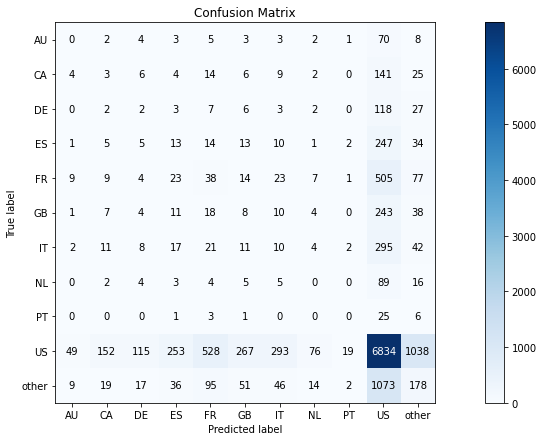

In [50]:
# balanced accuracy, accuracy, kappa score 
dic = {
    'model': 'NN',
    'Accuracy': accuracy_score( y_val_nn, yhat_random ),
    'BalancedAccuracy': balanced_accuracy_score( y_val_nn, yhat_random ),
    'KappaScore': cohen_kappa_score( y_val_nn, yhat_random )
}
print( pd.DataFrame( dic, index=[0] ) )
print( classification_report( y_val_nn, yhat_random ) )

# confusion matrix
plot_confusion_matrix(y_val_nn, yhat_random, figsize=(18,7) );

## 7.2. NN 

In [23]:
on = OneHotEncoder()
y_train_nn = on.fit_transform( y_train.values.reshape(-1,1) ).toarray()

In [24]:
# model definition
model = models.Sequential()
model.add( layers.Dense( 128, input_dim=X_train.shape[1], activation='relu' ) )
model.add( layers.Dense( 11, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( X_train, y_train_nn, epochs=100 )

Epoch 1/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.3177 - accuracy: 0.7054
Epoch 2/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.2520 - accuracy: 0.7081
Epoch 3/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.2223 - accuracy: 0.7084
Epoch 4/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.2046 - accuracy: 0.7084
Epoch 5/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1824 - accuracy: 0.7085
Epoch 6/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.1762 - accuracy: 0.7086
Epoch 7/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.1594 - accuracy: 0.7085
Epoch 8/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1512 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1424 - accuracy: 0.7087
Epoch 10/100
1705/1705 [==============================] - 3s 2ms/step - l

1705/1705 [==============================] - 3s 1ms/step - loss: 1.1000 - accuracy: 0.7115
Epoch 80/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.1006 - accuracy: 0.7114
Epoch 81/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.0997 - accuracy: 0.7115
Epoch 82/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0997 - accuracy: 0.7118
Epoch 83/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.0992 - accuracy: 0.7118
Epoch 84/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.0989 - accuracy: 0.7116
Epoch 85/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0986 - accuracy: 0.7118
Epoch 86/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0989 - accuracy: 0.7117
Epoch 87/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0989 - accuracy: 0.7117
Epoch 88/100
1705/1705 [==============================] - 3s 1ms/step - loss:

# 8.0. Model Performance 

In [25]:
# prediction
pred_nn = model.predict( X_val )

# invert prediction
yhat_nn =  on.inverse_transform( pred_nn )

# prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape( 1,-1 )[0]

  model  Accuracy  BalancedAccuracy  KappaScore
0    NN  0.703777          0.091323    0.001141


C:\Users\Marcos\Projects\airbnb_prediction\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marcos\Projects\airbnb_prediction\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Marcos\Projects\airbnb_prediction\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.00      0.00      0.00       170
          ES       0.00      0.00      0.00       345
          FR       0.09      0.00      0.00       710
          GB       0.17      0.00      0.01       344
          IT       0.25      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.14      0.00      0.00      1540

    accuracy                           0.70     13635
   macro avg       0.12      0.09      0.08     13635
weighted avg       0.53      0.70      0.58     13635



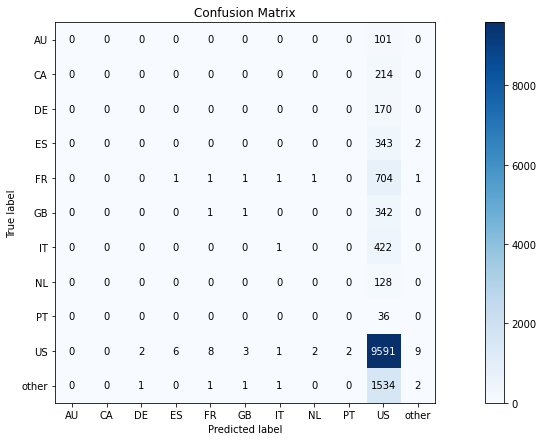

In [34]:
# balanced accuracy, accuracy, kappa score 
dic = {
    'model': 'NN',
    'Accuracy': accuracy_score( y_val_nn, yhat_nn ),
    'BalancedAccuracy': balanced_accuracy_score( y_val_nn, yhat_nn ),
    'KappaScore': cohen_kappa_score( y_val_nn, yhat_nn )
}
print( pd.DataFrame( dic, index=[0] ) )
print( classification_report( y_val_nn, yhat_nn ) )

# confusion matrix
plot_confusion_matrix(y_val_nn, yhat_nn, figsize=(18,7) );